# P1
## Método de sobrerelajación para la capacitancia de un condensador no trivial

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation

def sor_n(n):
    # Parametros
    N = n
    M = N
    deltar = 1. / (N + 1)
    deltat = M // 5
    V = 1.
    L = 1.
    R = L/4

    # Crea arreglo de coordenadas
    i_idx, j_idx = np.meshgrid(np.arange(1, N + 1), np.arange(1, N + 1))
    x_vals = np.arange(N) * deltar

    # Definición de máscara circular central
    x = np.linspace(0, L, N + 2)
    y = np.linspace(0, L, N + 2)
    X, Y = np.meshgrid(x, y)
    circle_mask = (X - L/2)**2 + (Y - L/2)**2 < R**2

    # Inicializa arreglos
    v = np.zeros((N + 2, N + 2))
    v_old = np.zeros((N, N))
    v1 = np.zeros((N, N))

    # Potenciales en bordes
    v[0, :] = V
    v[-1, :] = V
    v[:, 0] = V
    v[:, -1] = V

    v[circle_mask] = -V

    w = 2. / (1 + np.pi / N)

    # Arreglos
    err_sor = np.empty(M)

    count = 0
    for k in range(M):
        # Snapshot de la solucion cada deltat iteraciones
        if k % deltat == 0:
            print(f'count={count}')
            plt.figure(figsize=(6, 5))
            plt.imshow(v, extent=[0, L, 0, L], origin='lower', cmap='hot_r')
            plt.colorbar(label='Potencial')
            plt.title(f'Iteración {k}')
            plt.show()
            count += 1
            
        # Método SOR y cálculo de error
        v_old[:,:] = v[1:-1, 1:-1]#.copy()
        for i in range(1, N + 1):
            for j in range(1, N + 1):
                resid = (v[i + 1, j] + v[i - 1, j] + v[i, j + 1] + v[i, j - 1] - 4. * v[i, j])
                v[i, j] += 0.25 * w * resid

                # Bordes por iteración
                v[0, :] = V
                v[-1, :] = V
                v[:, 0] = V
                v[:, -1] = V
                v[circle_mask] = -V
                

        diff = v[1:-1, 1:-1] - v_old
        err_sor[k] = np.sqrt(np.mean(diff ** 2))

    # Crear máscara del círculo y su borde
    circle_mask = (X - L/2)**2 + (Y - L/2)**2 < R**2
    circle_dilated = binary_dilation(circle_mask)
    circle_border = circle_dilated & ~circle_mask

    # Inicializar carga total
    Q = 0.0

    # Recorre los puntos de la frontera
    for i in range(1, N + 1):
        for j in range(1, N + 1):
            if circle_border[i, j]:
                # Derivadas centradas
                dv_dx = (v[i, j+1] - v[i, j-1]) / (2 * deltar)
                dv_dy = (v[i+1, j] - v[i-1, j]) / (2 * deltar)

                # Vector normal al círculo (aproximado)
                dx = X[i, j] - L/2
                dy = Y[i, j] - L/2
                norm = np.sqrt(dx**2 + dy**2)
                nx = dx / norm
                ny = dy / norm

                # Componente normal del campo eléctrico
                En = -(dv_dx * nx + dv_dy * ny)

                # Aproximar integral como suma: campo × elemento de borde
                Q += En * deltar  # deltar ≈ dl

    # Constante 1/4π
    Q *= 1 / (4 * np.pi)

    # Capacitancia
    C = Q / (2 * V)

    print(f"Capacitancia estimada: C = {C:.6f}")

    return C

    

count=0


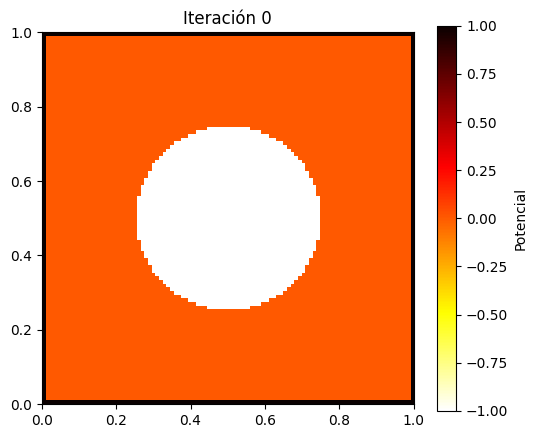

count=1


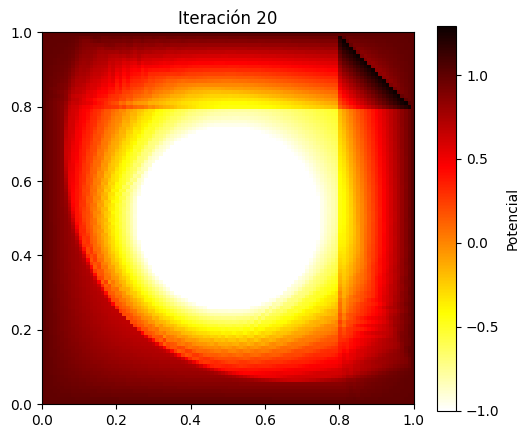

count=2


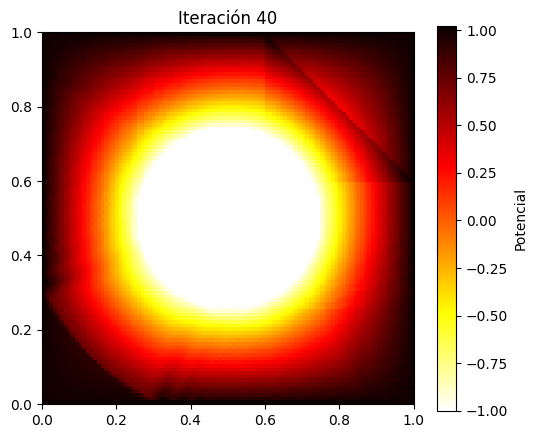

count=3


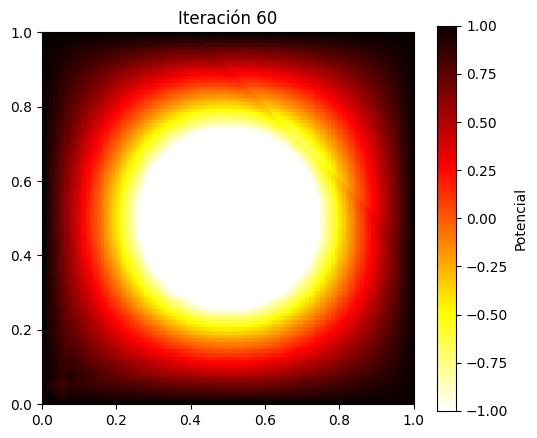

count=4


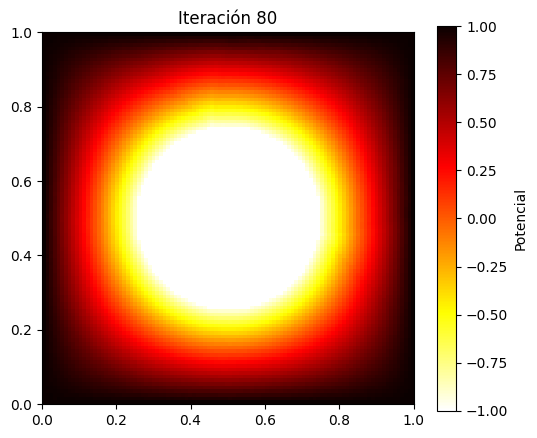

Capacitancia estimada: C = -0.554632


In [6]:
C_100 = sor_n(100)

count=0


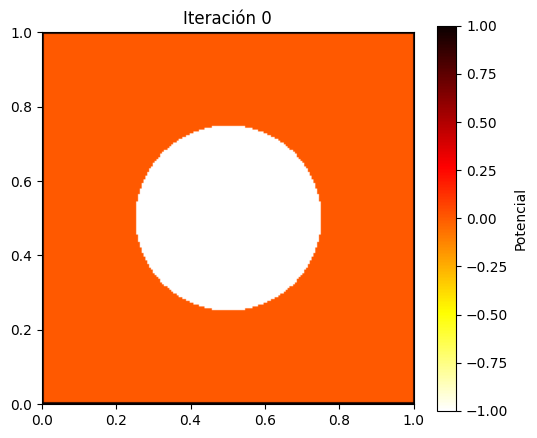

count=1


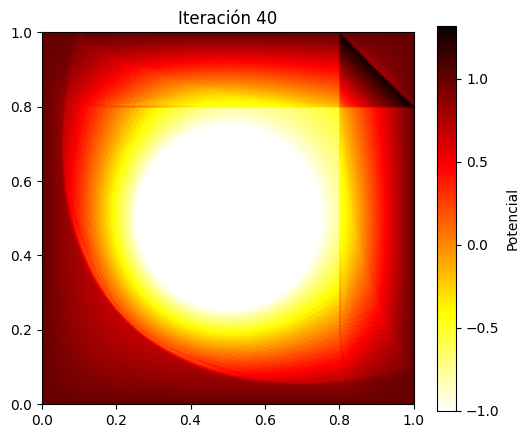

count=2


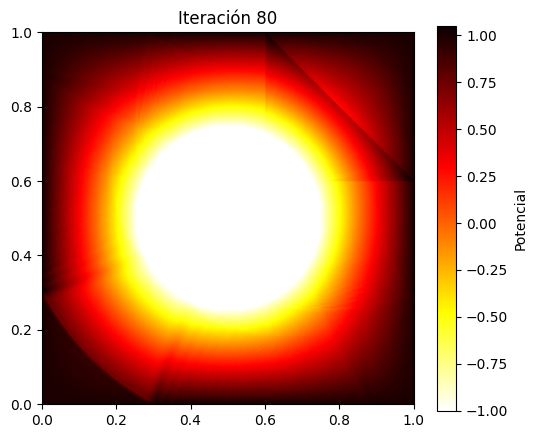

count=3


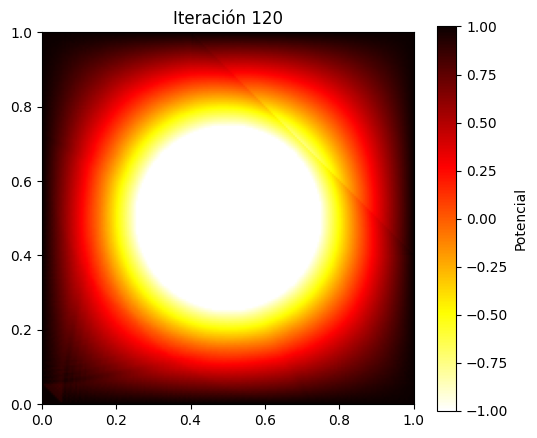

count=4


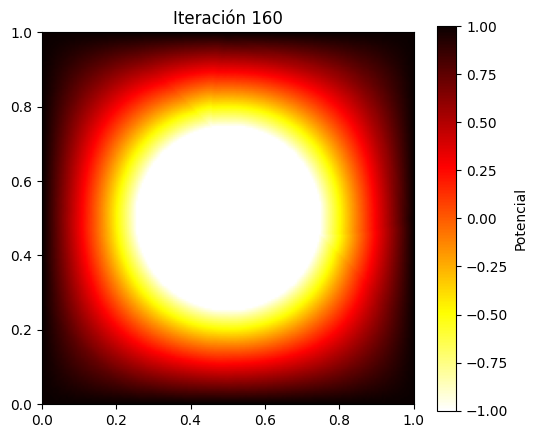

Capacitancia estimada: C = -0.565158


In [7]:
C_200 = sor_n(200)

In [10]:
difper = (C_100 - C_200)*100
print(f"Diferencia porcentual: {difper:.4f}%")

Diferencia porcentual: 1.0525%


# P2
## Método pseudo-espectral para la ecuación de Burger

j= 0
j= 1
j= 2
j= 3
j= 4


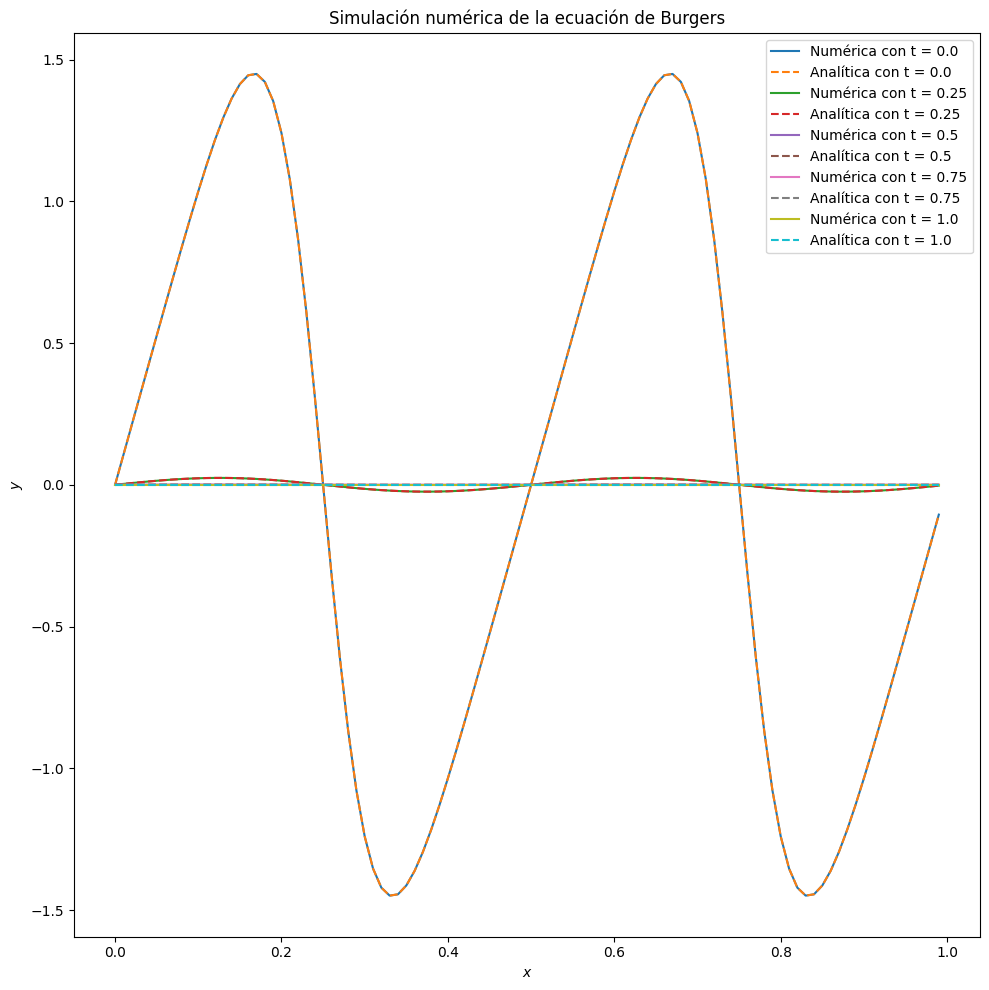

In [18]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import math

N=100 # numero de pasos espaciales
deltax = 1/N # paso espacial
v0=np.empty(N)
v_theo=np.empty(N)
x=np.empty(N)
nu = 0.1
k = 2

for i in range(N):
    v0[i] = (2*math.pi*k*nu*np.sin(2*math.pi*k*i/N))/(1 + 0.5*np.cos(2*math.pi*k*i/N))
    x[i] = i/N

def derivada(v,t):
    vf = np.fft.fft(v)
    freq = 2*np.pi*np.fft.fftfreq(N, d=1/N)

    # Derivadas
    du = (np.fft.ifft(1j * freq * vf)).real
    d2u = (np.fft.ifft(-(freq**2) * vf)).real

    # No lineal
    nonlinear = v * du


    # Viscoso
    visc = nu * d2u

    return - nonlinear + visc

L = 5
t = np.array([0.25 * j for j in range(L)])
u = odeint(derivada, v0, t)
plt.figure(figsize = (10,10))
plt.xlabel('$x$')
plt.ylabel('$y$')
for j in range(L):
    exp = np.exp(-4*(k**2)*nu*(math.pi**2)*t[j])
    for i in range(N):
        v_theo[i] = (2*math.pi*k*nu*exp*np.sin(2*math.pi*k*i/N))/(1 + 0.5*exp*np.cos(2*math.pi*k*i/N))
    print("j=", j)
    plt.plot(x, u[j, :], label = f'Numérica con t = {0.25*j}')
    plt.plot(x, v_theo, linestyle = 'dashed', label = f'Analítica con t = {0.25*j}')
plt.title('Simulación numérica de la ecuación de Burgers')
plt.tight_layout()
plt.legend()
plt.show()